In [1]:
# This notebook is a study into the utility of autoencoders for RL agents

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import gym
from gym import wrappers

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [3]:
cartpole = gym.make("CartPole-v1")
cartpole = wrappers.Monitor(cartpole, ".", video_callable=False ,force=True)

/home/luke/anaconda3/envs/autoencoders/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [4]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def get_screen(env):
    # Grab the grb screen values
    rend = env.render(mode='rgb_array')
    
    # Convert to grayscale
    gray = rgb2gray(rend)
    
    # Downsample 4x
    d_gray = gray[::4,::4]
    
    return d_gray
    
def plt_screen(screen):
    plt.imshow(screen, cmap = plt.get_cmap('gray'))
    
SCREEN_DIMS = np.array([100, 150])

In [5]:
class ScreenBuffer:
    
    def __init__(self):
        self.memory = list()
        
    def __len__(self):
        return len(self.memory)
    
    def add(self, frame):
        self.memory.append(frame) 
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

In [6]:
# Network                                                                                 
class AutoEncoder(nn.Module):                                                             
    def __init__(self):                                                                   
        super(AutoEncoder, self).__init__()                                               

        # 3 passes down to 100 dims                                                       
        # 3 passes back up to 28*28                                                       
        self.fc1 = nn.Linear(np.prod(SCREEN_DIMS), 500)                                                  
        self.fc2 = nn.Linear(500, 256)                                                    
        self.fc3 = nn.Linear(256, 100)                                                    

        self.fc4 = nn.Linear(100, 256)                                                    
        self.fc5 = nn.Linear(256, 500)                                                    
        self.fc6 = nn.Linear(500, np.prod(SCREEN_DIMS))  
        
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001, weight_decay=1e-5)

    def forward(self, x):                                                                 
        x = x.view(-1, np.prod(SCREEN_DIMS))                                                             
        x = F.relu(self.fc1(x))                                                           
        x = F.relu(self.fc2(x))                                                           
        x = F.relu(self.fc3(x))                                                           
        x = F.relu(self.fc4(x))                                                           
        x = F.relu(self.fc5(x))                                                           
        x = self.fc6(x)                                                                   
        return x                                                                          

    def name(self):                                                                       
        return "AutoEncoder"

def loss_function(input, target):                                                              
    return torch.sum((input - target) ** 2)  

In [19]:
def train_autoencoder(num_epochs, screen_buffer, batch_size):
    model = AutoEncoder()
    
    for epoch in range(num_epochs):
        
        model.train()
        train_loss = 0

        batch = screen_buffer.sample(batch_size)

        for batch_idx, frames in enumerate(batch):
            model.optimizer.zero_grad()
            
            x = Variable(torch.from_numpy(frames).float(), requires_grad=False)
            
            reconstructed_batch = model(x)
            
            loss = loss_function(reconstructed_batch, x.view(-1, np.prod(SCREEN_DIMS)))
            loss.backward()
            train_loss += loss.item()
            
            model.optimizer.step() 
        
        print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(screen_buffer)))
    
    return model

In [17]:
# Collect data

def collectData(env, num_samples):
    
    env_actions = env.action_space.n
    buffer = ScreenBuffer()
    
    sample_count = 0
    while sample_count < num_samples:
        
        env.reset()
        done = False
        t = 0
        while (not done):
            
            action = np.random.randint(env_actions)
            
            _, _, done, _ = env.step(action)
            buffer.add(get_screen(env))
            env.viewer = None
            
            if sample_count == num_samples:
                done = True
                
            t += 1
            sample_count += 1
        
    env.close()
    return buffer, len(buffer)

In [9]:
buffer, buffer_len = collectData(cartpole.env, 500)

In [10]:
buffer_len

501

In [11]:
# print("Number frames: {}".format(len(buffer)))
# fig, ax = plt.subplots(figsize=(5,8))

# def update(i):
      
#     ax.imshow(buffer.memory[i], cmap = plt.get_cmap('gray'))
#     ax.set_title("Frame: {}".format(i), fontsize=20)
#     ax.set_axis_off()


# anim = FuncAnimation(fig, update, frames=np.arange(len(buffer)), interval=50)

In [12]:
# HTML(anim.to_html5_video())

In [20]:
# Train autoencoder

num_epochs = 10
batch_size = 64
model = train_autoencoder(num_epochs, buffer, batch_size)

====> Epoch: 0 Average loss: 7635030.5519
====> Epoch: 1 Average loss: 303120.6755
====> Epoch: 2 Average loss: 212208.4890
====> Epoch: 3 Average loss: 247327.7858
====> Epoch: 4 Average loss: 228193.1637
====> Epoch: 5 Average loss: 275181.2090
====> Epoch: 6 Average loss: 250357.2651
====> Epoch: 7 Average loss: 391114.3617
====> Epoch: 8 Average loss: 869112.1725
====> Epoch: 9 Average loss: 217120.5684


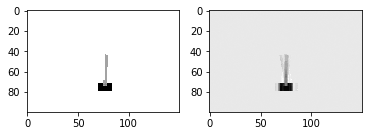

In [46]:
img = buffer.memory[0]
img = torch.from_numpy(img).type(torch.FloatTensor)
img.unsqueeze_(0)

recon_img = model.forward(img)
recon_img = recon_img.view(-1, 100, 150, 1).detach()

fig, (ax1, ax2) = plt.subplots(1,2)

ax1.imshow(buffer.memory[0], cmap=plt.get_cmap('gray'))
ax2.imshow(np.squeeze(recon_img), cmap=plt.get_cmap('gray'))